In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
import time
import pickle
import os
from pycbc.types import timeseries
from calcwf import shifted_f, shifted_e, P_from_f, num_orbits, peri_advance_orbit, gen_wf, get_h, trim_wf, chirp2total, get_h, overlap_cplx_wfs, match_wfs, ceiltwo

In [2]:
e_params = [0.05, 0.1, 0.2]
chirp_params = [10, 24, 50]

# Generate training waveforms

In [3]:
# Generates n training waveforms equally spaced in true anomaly
def gen_training_wfs(f_low, e, M, q, n, sample_rate, approximant):

    # Generate shifted frequency, eccentricity, phase values
    max_s_f = shifted_f(f_low, e, M, q)
    s_f_vals = np.linspace(f_low, max_s_f, n, endpoint=False)
    s_e_vals = shifted_e(s_f_vals, f_low, e)

    training_wfs = []
    # Generate all training waveforms
    for i, (s_f, s_e) in enumerate(zip(s_f_vals, s_e_vals)):

        # Create waveform
        h = gen_wf(s_f, s_e, M, q, sample_rate, approximant, phase=0)

        # Trim waveform to same size as first (shortest), and corrects phase
        if i > 0:
            h = trim_wf(h, training_wfs[0])
            overlap = overlap_cplx_wfs(h, training_wfs[0], f_low)
            phase_angle = +np.angle(overlap)/2
            h = gen_wf(s_f, s_e, M, q, sample_rate, approximant, phase=phase_angle)
            h = trim_wf(h, training_wfs[0])
        
        h.resize(ceiltwo(len(h)))   
        training_wfs.append(h)

        # Progress bar
        print(f'\r{i+1} done out of {n}.', end='')

    return training_wfs

In [4]:
# Generates all training waveforms
all_training_wfs = []
for e in e_params:
    all_training_wfs.append([])
    for chirp in chirp_params:
        start = time.time()
        training_wfs = gen_training_wfs(10, e, chirp2total(chirp, 2), 2, 100, 1024, 'TEOBResumS')
        all_training_wfs[-1].append(training_wfs)
        end = time.time()
        print(f'\n{e}, {chirp} finished in {end-start} seconds')

100 done out of 100.
0.05, 10 finished in 1177.4787619113922 seconds
100 done out of 100.
0.05, 24 finished in 249.31117868423462 seconds
100 done out of 100.
0.05, 50 finished in 63.45484495162964 seconds
100 done out of 100.
0.1, 10 finished in 1287.840582370758 seconds
100 done out of 100.
0.1, 24 finished in 272.3482120037079 seconds
100 done out of 100.
0.1, 50 finished in 69.36547446250916 seconds
100 done out of 100.
0.2, 10 finished in 1298.4966385364532 seconds
100 done out of 100.
0.2, 24 finished in 266.57059025764465 seconds
100 done out of 100.
0.2, 50 finished in 67.65635204315186 seconds


# Performing SVD

In [5]:
# Convert training wf data to np array in right shape/form and calc svd
all_U = []
all_S = []
all_Vh = []
for i in range(len(e_params)):
    all_U.append([])
    all_S.append([])
    all_Vh.append([])
    for j in range(len(chirp_params)):
        start = time.time()
        X = np.array(all_training_wfs[i][j]).T
        means = X.mean(axis=0) 
        stds = X.std(axis=0) 
        U, S, Vh = np.linalg.svd((X-means)/stds)
        all_U[-1].append(U)
        all_S[-1].append(S)
        all_Vh[-1].append(Vh)
        end = time.time()
        print(f'{e_params[i]}, {chirp_params[j]} finished in {end-start} seconds')

0.05, 10 finished in 597.8462345600128 seconds
0.05, 24 finished in 36.71122741699219 seconds
0.05, 50 finished in 1.956341028213501 seconds
0.1, 10 finished in 636.2616567611694 seconds
0.1, 24 finished in 35.624069690704346 seconds
0.1, 50 finished in 2.3012912273406982 seconds
0.2, 10 finished in 644.8856821060181 seconds
0.2, 24 finished in 37.68812298774719 seconds
0.2, 50 finished in 2.318255662918091 seconds


# Relative importance

In [8]:
# Calculate relative importances
all_rel_imports = []
for i in range(len(e_params)):
    all_rel_imports.append([])
    for j in range(len(chirp_params)):
        rel_imports = []
        for k in range(len(all_S[i][j])):
            rel_imports.append(S[k]**2/np.sum(S**2))
        all_rel_imports[-1].append(rel_imports)

Text(0, 0.5, 'Fractional importance')

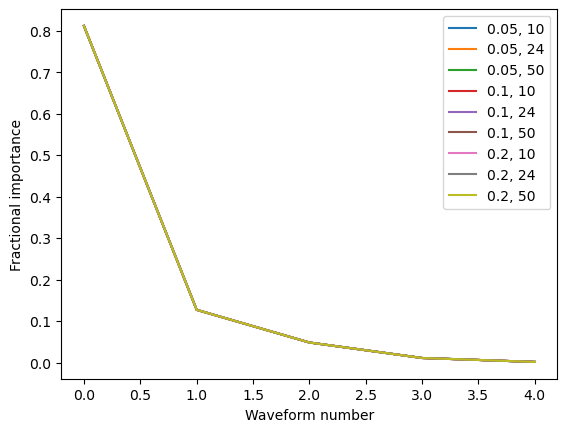

In [9]:
# Plot relative importance
for i in range(len(e_params)):
    for j in range(len(chirp_params)):
        plt.plot(np.arange(5), all_rel_imports[i][j][:5], label=f'{e_params[i]}, {chirp_params[j]}')
plt.legend()
plt.xlabel('Waveform number')
plt.ylabel('Fractional importance')

# U waveforms

/home/ben.patterson/.conda/envs/teobresums_eccentric/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0.92, 'First waveform')

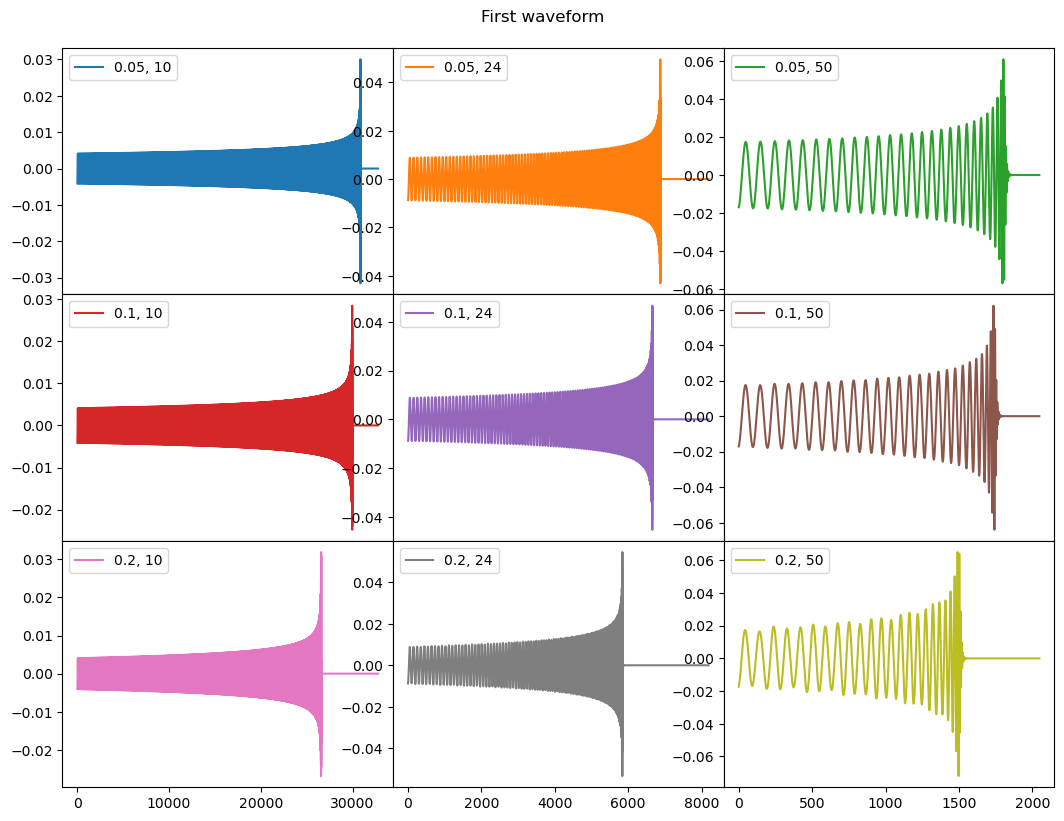

In [10]:
# First waveform
plt.figure(figsize=(6.4*2,4.8*2))
for i in range(len(e_params)):
    for j in range(len(chirp_params)):
        plt.subplot(len(e_params), len(chirp_params), i*3+j+1)
        plt.plot(np.arange(len(all_U[i][j].T[0])), all_U[i][j].T[0], c=f'C{i*3+j}', label=f'{e_params[i]}, {chirp_params[j]}')
        plt.legend()
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle('First waveform', x=0.5, y=0.92)

Text(0.5, 0.92, 'Second waveform')

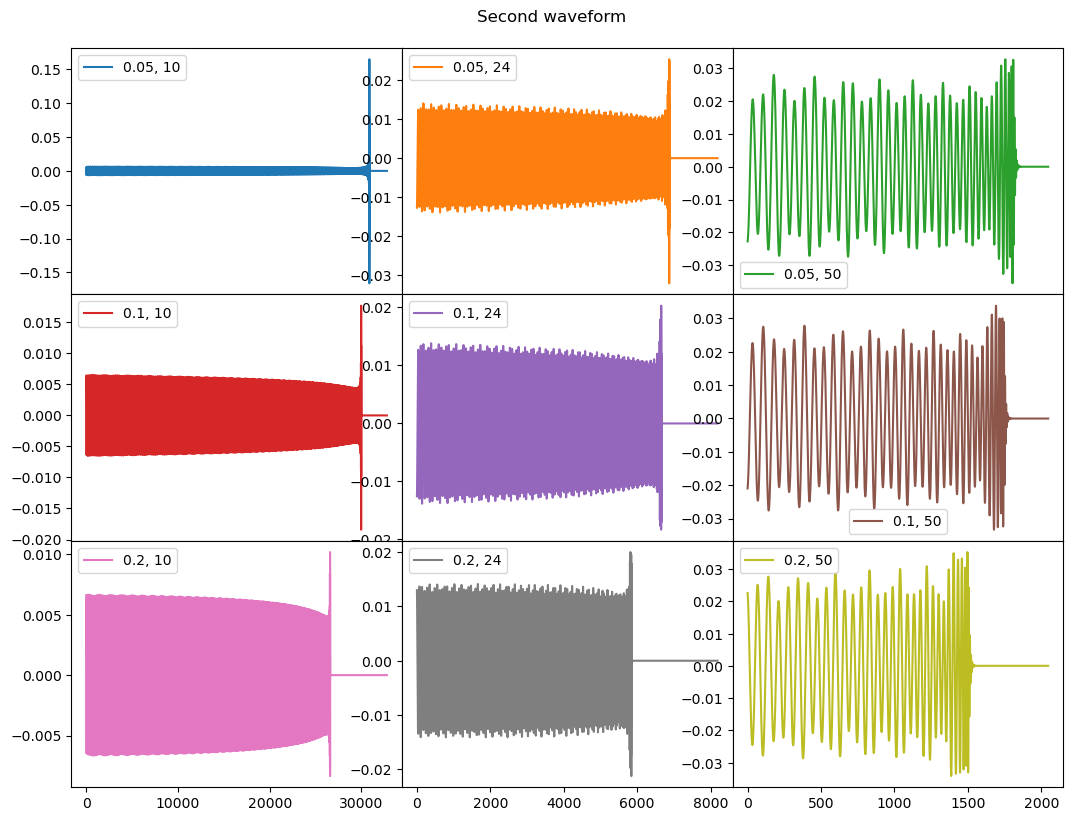

In [11]:
# Second waveform
plt.figure(figsize=(6.4*2,4.8*2))
for i in range(len(e_params)):
    for j in range(len(chirp_params)):
        plt.subplot(len(e_params), len(chirp_params), i*3+j+1)
        plt.plot(np.arange(len(all_U[i][j].T[1])), all_U[i][j].T[1], c=f'C{i*3+j}', label=f'{e_params[i]}, {chirp_params[j]}')
        plt.legend()
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle('Second waveform', x=0.5, y=0.92)

Text(0.5, 0.92, 'Third waveform')

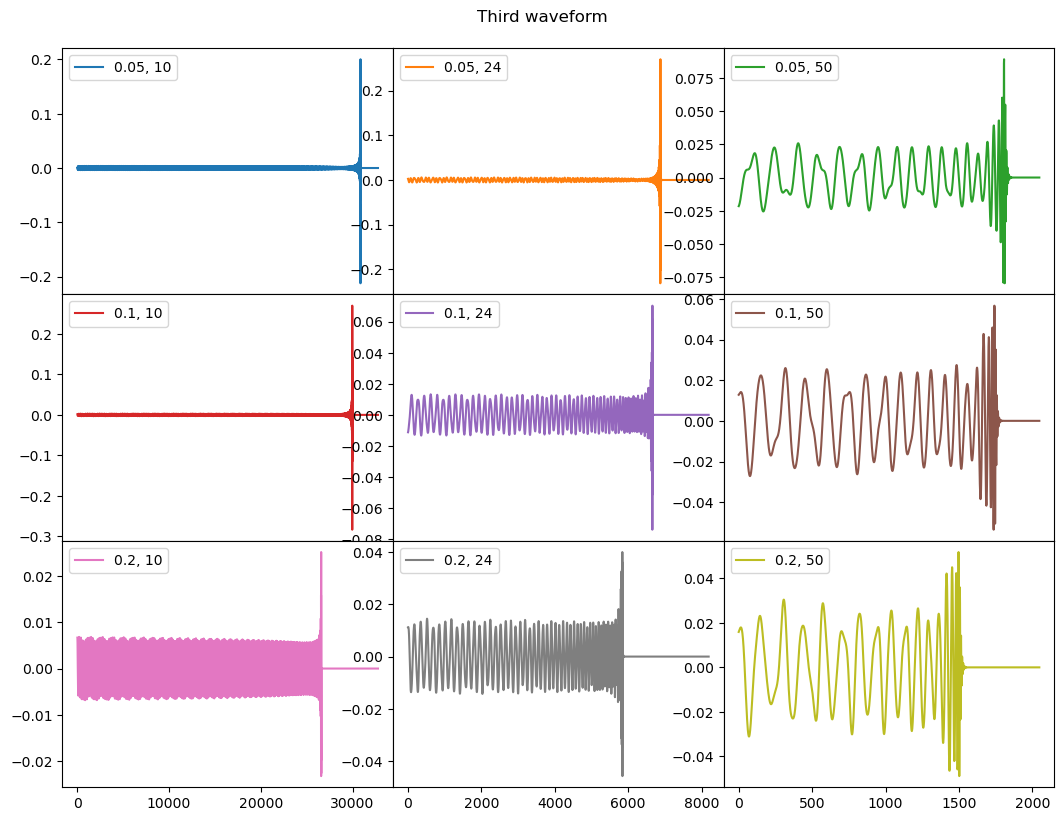

In [12]:
# Third waveform
plt.figure(figsize=(6.4*2,4.8*2))
for i in range(len(e_params)):
    for j in range(len(chirp_params)):
        plt.subplot(len(e_params), len(chirp_params), i*3+j+1)
        plt.plot(np.arange(len(all_U[i][j].T[2])), all_U[i][j].T[2], c=f'C{i*3+j}', label=f'{e_params[i]}, {chirp_params[j]}')
        plt.legend()
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle('Third waveform', x=0.5, y=0.92)

# Solving for U

In [14]:
# Solve for U
all_Vinv_S = []
for i in range(len(e_params)):
    all_Vinv_S.append([])
    for j in range(len(chirp_params)):
        Vinv_S = np.matmul(all_Vh[i][j].T.conj(), np.diag(1/all_S[i][j]))
        all_Vinv_S[-1].append(Vinv_S)

Text(0.5, 1.0, 'First waveform')

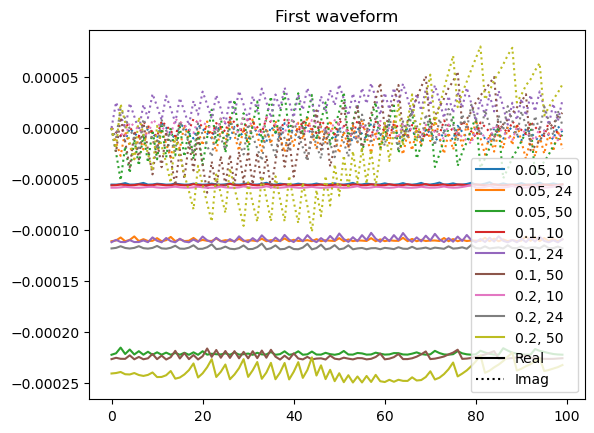

In [15]:
# First waveform
for i in range(len(e_params)):
    for j in range(len(chirp_params)):
        plt.plot(np.arange(len(all_Vinv_S[i][j].T[0])), np.real(all_Vinv_S[i][j].T[0]), c=f'C{i*3+j}', label=f'{e_params[i]}, {chirp_params[j]}')
        plt.plot(np.arange(len(all_Vinv_S[i][j].T[0])), np.imag(all_Vinv_S[i][j].T[0]), c=f'C{i*3+j}', ls='dotted')
plt.plot([1],[0],c='k',label='Real')
plt.plot([1],[0],c='k',ls='dotted', label='Imag')
plt.legend()
plt.title('First waveform')

Text(0.5, 1.0, 'Second waveform')

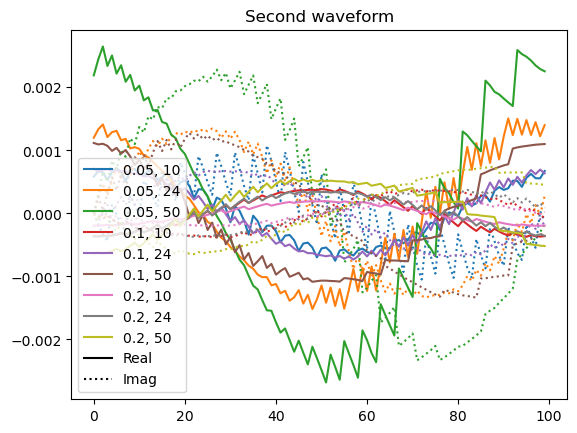

In [16]:
# Second waveform
for i in range(len(e_params)):
    for j in range(len(chirp_params)):
        plt.plot(np.arange(len(all_Vinv_S[i][j].T[1])), np.real(all_Vinv_S[i][j].T[1]), c=f'C{i*3+j}', label=f'{e_params[i]}, {chirp_params[j]}')
        plt.plot(np.arange(len(all_Vinv_S[i][j].T[1])), np.imag(all_Vinv_S[i][j].T[1]), c=f'C{i*3+j}', ls='dotted')
plt.plot([1],[0],c='k',label='Real')
plt.plot([1],[0],c='k',ls='dotted', label='Imag')
plt.legend()
plt.title('Second waveform')

Text(0.5, 1.0, 'Third waveform')

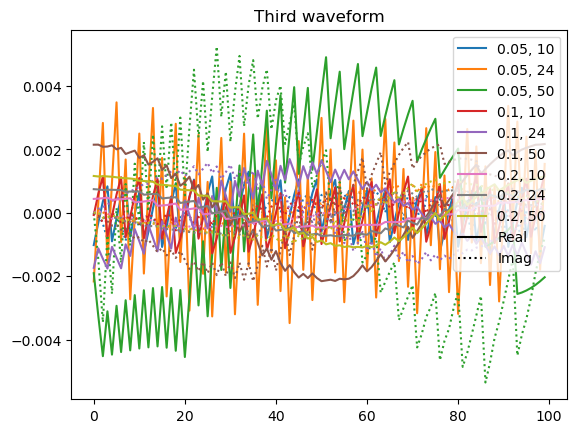

In [17]:
# Third waveform
for i in range(len(e_params)):
    for j in range(len(chirp_params)):
        plt.plot(np.arange(len(all_Vinv_S[i][j].T[2])), np.real(all_Vinv_S[i][j].T[2]), c=f'C{i*3+j}', label=f'{e_params[i]}, {chirp_params[j]}')
        plt.plot(np.arange(len(all_Vinv_S[i][j].T[2])), np.imag(all_Vinv_S[i][j].T[2]), c=f'C{i*3+j}', ls='dotted')
plt.plot([1],[0],c='k',label='Real')
plt.plot([1],[0],c='k',ls='dotted', label='Imag')
plt.legend()
plt.title('Third waveform')